In [1]:
from pip._internal import main
try:
    import pymc3 as pm
except:
    from pip._internal import main
    main(['install', 'pymc3'])
    import pymc3 as pm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\User\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


In [2]:
data = pd.read_csv("ratingdf_likescore.csv")
data.head()

,Unnamed: 0,session_id,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,hist_user_behavior_reason_start,hist_user_behavior_reason_end,hist_user_behavior_is_shuffle,skip_score,liking,rating
0,0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0.0,0.0,1,0,1.0,1.0,1,1.0,3.0,4.0
1,1,0_00079a23-1600-486a-91bd-5208be0c745a,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0.0,0.2,0,0,0.3,0.4,0,0.2,0.7,0.9
2,2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0.0,0.0,1,0,1.0,1.0,0,1.0,2.0,3.0
3,3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0.0,0.0,1,0,0.3,1.0,0,1.0,1.3,2.3
4,4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0.0,0.2,0,0,1.0,0.3,1,0.2,2.3,2.5


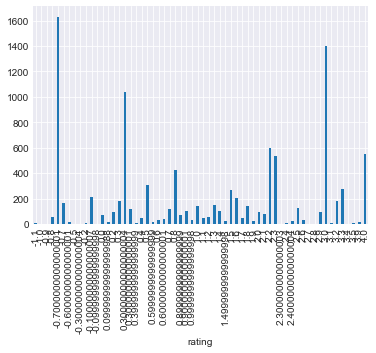

In [3]:
# Extract the ratings from the DataFrame
ratings = data.rating

# Plot histogram
data.groupby('rating').size().plot(kind='bar');

In [4]:
data.rating.describe()

count    10000.000000
mean         1.326170
std          1.472203
min         -1.100000
25%          0.300000
50%          1.200000
75%          2.900000
max          4.000000
Name: rating, dtype: float64

In [5]:
tracks = pd.read_csv('tf_mini.csv')

In [6]:
track_means = pd.merge(data, tracks, on='track_id').groupby('track_id').rating.mean()

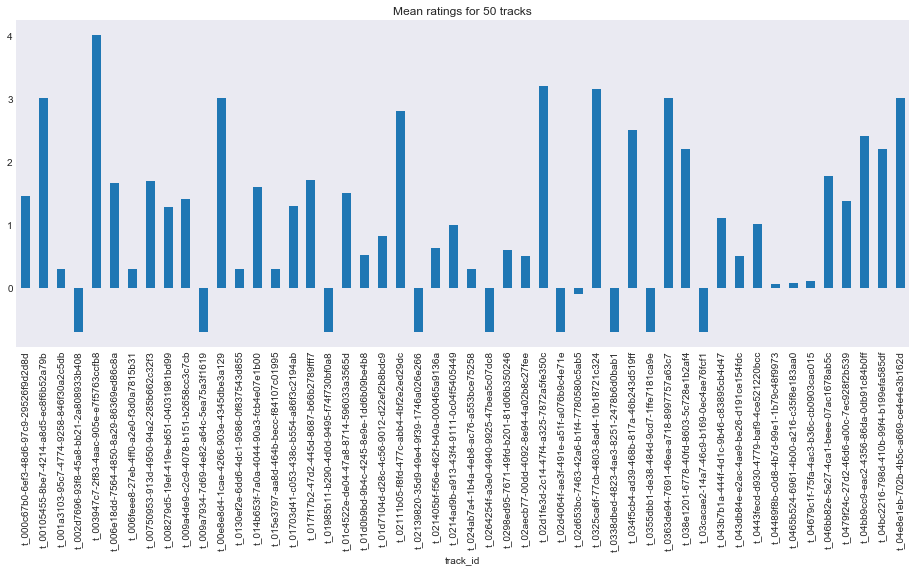

In [7]:
track_means[:50].plot(kind='bar', grid=False, figsize=(16, 6),
                      title="Mean ratings for 50 tracks");

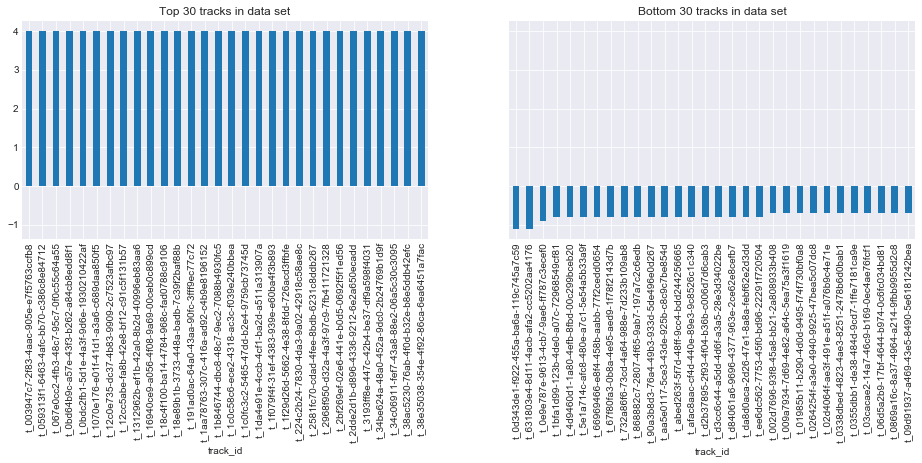

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4), sharey=True)
track_means.nlargest(30).plot(kind='bar', ax=ax1,title="Top 30 tracks in data set");
track_means.nsmallest(30).plot(kind='bar', ax=ax2,title="Bottom 30 tracks in data set");

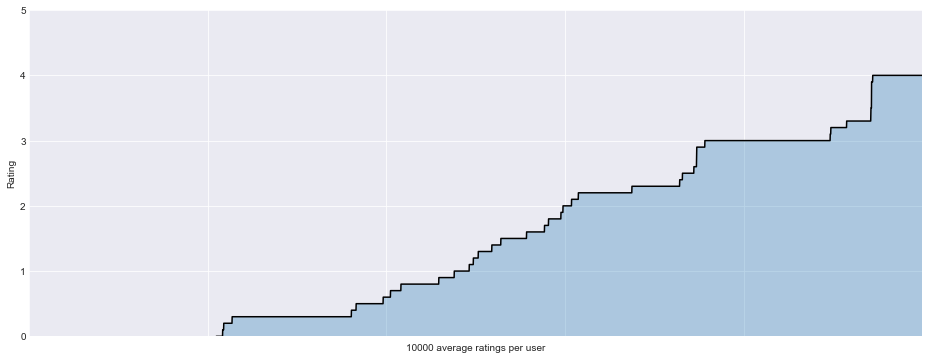

In [9]:
user_means = data.groupby('session_id').rating.mean().sort_values()
_, ax = plt.subplots(figsize=(16, 6))
ax.plot(np.arange(len(user_means)), user_means.values, 'k-')

ax.fill_between(np.arange(len(user_means)), user_means.values, alpha=0.3)
ax.set_xticklabels('');  # 1000 labels is nonsensical
ax.set_ylabel('Rating')
ax.set_xlabel(f'{len(user_means)} average ratings per user')
ax.set_ylim(0, 5)
ax.set_xlim(0, len(user_means));

# Baselines

In [10]:
def split_title(title):
    """Change "BaselineMethod" to "Baseline Method"."""
    words = []
    tmp = [title[0]]
    for c in title[1:]:
        if c.isupper():
            words.append(''.join(tmp))
            tmp = [c]
        else:
            tmp.append(c)
    words.append(''.join(tmp))
    return ' '.join(words)


class Baseline():
    """Calculate baseline predictions."""

    def __init__(self, train_data):
        """Simple heuristic-based transductive learning to fill in missing
        values in data matrix."""
        self.predict(train_data.copy())

    def predict(self, train_data):
        raise NotImplementedError(
            'baseline prediction not implemented for base class')

    def rmse(self, test_data):
        """Calculate root mean squared error for predictions on test data."""
        return rmse(test_data, self.predicted)

    def __str__(self):
        return split_title(self.__class__.__name__)


# Implement the 3 baselines.

class UniformRandomBaseline(Baseline):
    """Fill missing values with uniform random values."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        pmin, pmax = masked_train.min(), masked_train.max()
        N = nan_mask.sum()
        train_data[nan_mask] = np.random.uniform(pmin, pmax, N)
        self.predicted = train_data


class GlobalMeanBaseline(Baseline):
    """Fill in missing values using the global mean."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data


class MeanOfMeansBaseline(Baseline):
    """Fill in missing values using mean of user/item/global means."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        global_mean = masked_train.mean()
        user_means = masked_train.mean(axis=1)
        item_means = masked_train.mean(axis=0)
        self.predicted = train_data.copy()
        n, m = train_data.shape
        for i in range(n):
            for j in range(m):
                if np.ma.isMA(item_means[j]):
                    self.predicted[i, j] = np.mean(
                        (global_mean, user_means[i]))
                else:
                    self.predicted[i, j] = np.mean(
                        (global_mean, user_means[i], item_means[j]))


baseline_methods = {}
baseline_methods['ur'] = UniformRandomBaseline
baseline_methods['gm'] = GlobalMeanBaseline
baseline_methods['mom'] = MeanOfMeansBaseline

In [11]:
num_users = data.session_id.unique().shape[0]
num_items = data.track_id.unique().shape[0]
sparsity = 1 - len(data) / (num_users * num_items)
print(f"Users: {num_users}\nTracks: {num_items}\nSparsity: {sparsity}")

dense_data = data.pivot(index = 'session_id', columns ='track_id', values = 'rating').values

Users: 10000
Tracks: 3225
Sparsity: 0.9996899224806202


# Probabilistic Matrix Factorization

In [12]:
import time
import logging
import theano
import scipy as sp


# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
theano.config.compute_test_value = 'ignore'

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF():
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(1, 5)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info('building the PMF model')
        with pm.Model() as pmf:
            U = pm.MvNormal(
                'U', mu=0, tau=self.alpha_u * np.eye(dim),
                shape=(n, dim), testval=np.random.randn(n, dim) * std)
            V = pm.MvNormal(
                'V', mu=0, tau=self.alpha_v * np.eye(dim),
                shape=(m, dim), testval=np.random.randn(m, dim) * std)
            R = pm.Normal(
                'R', mu=(U @ V.T)[~nan_mask], tau=self.alpha,
                observed=self.data[~nan_mask])

        logging.info('done building the PMF model')
        self.model = pmf

    def __str__(self):
        return self.name

In [13]:
def _find_map(self):
    """Find mode of posterior using L-BFGS-B optimization."""
    tstart = time.time()
    with self.model:
        logging.info('finding PMF MAP using L-BFGS-B optimization...')
        self._map = pm.find_MAP(method='L-BFGS-B')

    elapsed = int(time.time() - tstart)
    logging.info('found PMF MAP in %d seconds' % elapsed)
    return self._map

def _map(self):
    try:
        return self._map
    except:
        return self.find_map()

# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.map = property(_map)

In [14]:
# Draw MCMC samples.
def _draw_samples(self, **kwargs):
    kwargs.setdefault('chains', 1)
    with self.model:
        self.trace = pm.sample(**kwargs)

# Update our class with the sampling infrastructure.
PMF.draw_samples = _draw_samples

In [15]:
def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.random.normal(R, self.std)
    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


PMF.predict = _predict

# Evaluation

In [16]:
# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N                 # mean squared error
    return np.sqrt(mse)                        # RMSE

In [17]:
# Define a function for splitting train/test data.
def split_train_test(data, percent_test=0.1):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape             # # users, # movies
    N = n * m                     # # cells in matrix

    # Prepare train/test ndarrays.
    train = data.copy()
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))       # ignore nan values in data
    idx_pairs = list(zip(tosample[0], tosample[1]))   # tuples of row/col index pairs

    test_size = int(len(idx_pairs) * percent_test)  # use 10% of data as test set
    train_size = len(idx_pairs) - test_size   # and remainder for training

    indices = np.arange(len(idx_pairs))         # indices of index pairs
    sample = np.random.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan          # remove from train set

    # Verify everything worked properly
    assert(train_size == N-np.isnan(train).sum())
    assert(test_size == N-np.isnan(test).sum())

    # Return train set and test set
    return train, test

train, test = split_train_test(dense_data)

# Results

In [18]:
# Let's see the results:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print('%s RMSE:\t%.5f' % (method, baselines[name]))

Uniform Random Baseline RMSE:	2.08600
Global Mean Baseline RMSE:	1.42764


C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:591: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


Mean Of Means Baseline RMSE:	nan


In [19]:
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each movie. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Movielens dataset, this means we have D(2625), so for 5
# dimensions, we are sampling 13125 latent variables.
DIM = 10


pmf = PMF(train, DIM, ALPHA, std=0.05)

INFO:root:building the PMF model
C:\Users\User\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
INFO:root:done building the PMF model


# Predictions using MAP

In [20]:
# Find MAP for PMF.
pmf.find_map();

INFO:root:finding PMF MAP using L-BFGS-B optimization...
logp = 54,919, ||grad|| = 29,920: 100%|██████████| 7/7 [00:17<00:00,  2.48s/it]
INFO:root:found PMF MAP in 1928 seconds


In [21]:
def eval_map(pmf_model, train, test):
    U = pmf_model.map['U']
    V = pmf_model.map['V']

    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print('PMF MAP training RMSE: %.5f' % train_rmse)
    print('PMF MAP testing RMSE:  %.5f' % test_rmse)
    print('Train/test difference: %.5f' % overfit)

    return test_rmse


# Add eval function to PMF class.
PMF.eval_map = eval_map

In [22]:
# Evaluate PMF MAP estimates.
pmf_map_rmse = pmf.eval_map(train, test)
pmf_improvement = baselines['mom'] - pmf_map_rmse
print('PMF MAP Improvement:   %.5f' % pmf_improvement)

PMF MAP training RMSE: 1.51223
PMF MAP testing RMSE:  1.45245
Train/test difference: -0.05978
PMF MAP Improvement:   nan


# Predictions using MCMC

In [23]:
# Draw MCMC samples.
pmf.draw_samples(draws=500, tune=500, )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [V, U]
INFO:pymc3:NUTS: [V, U]
Sampling chain 0, 0 divergences: 100%|█| 1000/1000 [30:46:29<00:00, 110.79s/it]  
The acceptance probability does not match the target. It is 0.9237935671842004, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


In [24]:
def _norms(pmf_model, monitor=('U', 'V'), ord='fro'):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """
    monitor = ('U', 'V')
    norms = {var: [] for var in monitor}
    for sample in pmf_model.trace:
        for var in monitor:
            norms[var].append(np.linalg.norm(sample[var], ord))
    return norms


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    trace_norms = pmf_model.norms()
    u_series = pd.Series(trace_norms['U'])
    v_series = pd.Series(trace_norms['V'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    u_series.plot(kind='line', ax=ax1, grid=False,
                  title="$\|U\|_{Fro}^2$ at Each Sample")
    v_series.plot(kind='line', ax=ax2, grid=False,
                  title="$\|V\|_{Fro}^2$ at Each Sample")
    ax1.set_xlabel("Sample Number")
    ax2.set_xlabel("Sample Number")


PMF.norms = _norms
PMF.traceplot = _traceplot

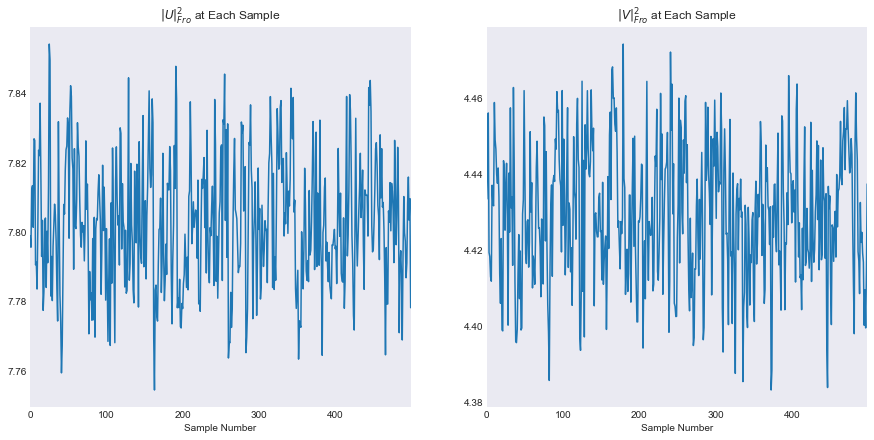

In [25]:
pmf.traceplot()

In [26]:
def _running_rmse(pmf_model, test_data, train_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence.
    """
    burn_in = burn_in if len(pmf_model.trace) >= burn_in else 0
    results = {'per-step-train': [], 'running-train': [],
               'per-step-test': [], 'running-test': []}
    R = np.zeros(test_data.shape)
    for cnt, sample in enumerate(pmf_model.trace[burn_in:]):
        sample_R = pmf_model.predict(sample['U'], sample['V'])
        R += sample_R
        running_R = R / (cnt + 1)
        results['per-step-train'].append(rmse(train_data, sample_R))
        results['running-train'].append(rmse(train_data, running_R))
        results['per-step-test'].append(rmse(test_data, sample_R))
        results['running-test'].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind='line', grid=False, figsize=(15, 7),
            title='Per-step and Running RMSE From Posterior Predictive')

    # Return the final predictions, and the RMSE calculations
    return running_R, results


PMF.running_rmse = _running_rmse

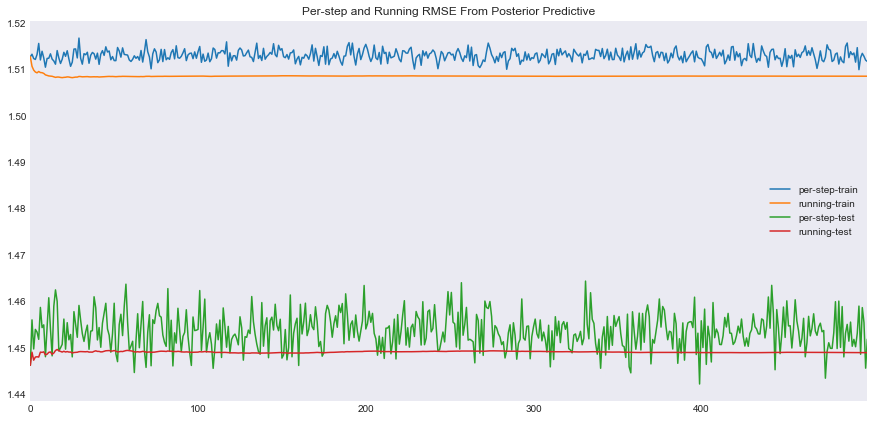

In [27]:
predicted, results = pmf.running_rmse(test, train)

In [28]:
# And our final RMSE?
final_test_rmse = results['running-test'].values[-1]
final_train_rmse = results['running-train'].values[-1]
print('Posterior predictive train RMSE: %.5f' % final_train_rmse)
print('Posterior predictive test RMSE:  %.5f' % final_test_rmse)
print('Train/test difference:           %.5f' % (final_test_rmse - final_train_rmse))
print('Improvement from MAP:            %.5f' % (pmf_map_rmse - final_test_rmse))
print('Improvement from Mean of Means:  %.5f' % (baselines['mom'] - final_test_rmse))

Posterior predictive train RMSE: 1.50849
Posterior predictive test RMSE:  1.44893
Train/test difference:           -0.05956
Improvement from MAP:            0.00352
Improvement from Mean of Means:  nan


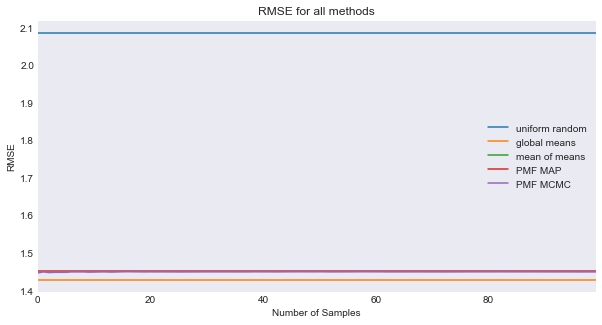

In [29]:
size = 100  # RMSE doesn't really change after 100th sample anyway.
all_results = pd.DataFrame({
    'uniform random': np.repeat(baselines['ur'], size),
    'global means': np.repeat(baselines['gm'], size),
    'mean of means': np.repeat(baselines['mom'], size),
    'PMF MAP': np.repeat(pmf_map_rmse, size),
    'PMF MCMC': results['running-test'][:size],
})
fig, ax = plt.subplots(figsize=(10, 5))
all_results.plot(kind='line', grid=False, ax=ax,
                 title='RMSE for all methods')
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE");